### Jorge P. Rodríguez, 2023
This notebook can be executed in Ocean Data Connector (Hub Ocean)

In [1]:
import pandas as pd
import geopandas as gp
import pylab as plt
import numpy as np
plt.style.use('classic')
import matplotlib.colors as colors
import matplotlib.colorbar as chi
import math

In [2]:
import odp.geospatial as odp

In [3]:
gd=odp.GridData()

In [4]:
ds=gd.open_dataset('Vessel Traffic and CO2 Emissions')
ds

,Array,Chunk
Bytes,6.79 GiB,7.63 MiB
Shape,"(28, 3972, 8194)","(1, 1000, 1000)"
Count,1009 Tasks,1008 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,6.79 GiB,7.63 MiB
Shape,"(28, 3972, 8194)","(1, 1000, 1000)"
Count,1009 Tasks,1008 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [5]:
del gd

In [6]:
#let's focus on Arctic and on total
ds_arctic = ds.sel(lat=slice(66.4,90.0),time=slice('2019-01-01','2022-12-31')
                ).hours_total.compute()
del ds

In [7]:
#discretization in cells of 0.25º x 0.25º
clat = []
for lat in ds_arctic.lat.values:
    clat.append(int(4*(lat-66.5)))
clon = []
for lon in ds_arctic.lon.values:
    clon.append(int(4*(180+lon)))
print(len(clat),len(clon))

538 8194


In [8]:
utimes = list(ds_arctic.time.values)
utimes.sort()
print(utimes,len(utimes))

[numpy.datetime64('2020-01-01T00:00:00.000000000'), numpy.datetime64('2020-02-01T00:00:00.000000000'), numpy.datetime64('2020-03-01T00:00:00.000000000'), numpy.datetime64('2020-04-01T00:00:00.000000000'), numpy.datetime64('2020-05-01T00:00:00.000000000'), numpy.datetime64('2020-06-01T00:00:00.000000000'), numpy.datetime64('2020-07-01T00:00:00.000000000'), numpy.datetime64('2020-08-01T00:00:00.000000000'), numpy.datetime64('2020-09-01T00:00:00.000000000'), numpy.datetime64('2020-10-01T00:00:00.000000000'), numpy.datetime64('2020-11-01T00:00:00.000000000'), numpy.datetime64('2020-12-01T00:00:00.000000000'), numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-02-01T00:00:00.000000000'), numpy.datetime64('2021-03-01T00:00:00.000000000'), numpy.datetime64('2021-04-01T00:00:00.000000000'), numpy.datetime64('2021-05-01T00:00:00.000000000'), numpy.datetime64('2021-06-01T00:00:00.000000000'), numpy.datetime64('2021-07-01T00:00:00.000000000'), numpy.datetime64('2021-08-01T0

In [9]:
Nlat = len(clat)
Nlon = len(clon)

In [10]:
cell = []
for i in range(Nlat):
    ct = []
    for j in range(Nlon):
        c = clon[j]+4*360*clat[i]
        ct.append(c)
    cell.append(ct)
del ct

In [14]:
R = 6371.
pi = np.pi
areas = []
for i in range(360*4*int(4*(90-66.5)+1)):
    cy = int(i/(4*360))
    lat = 66.5 + 0.25*i
    areas.append(R*R*abs(math.sin(pi*(lat+0.25)/180.)-math.sin(pi*(lat)/180.))*(0.25*pi/180.))
print(len(areas),360*4*int(4*(90-66.5)+1))

136800 136800


In [15]:
Nvis = []
timesv = []
areasv = []
for ix,time in enumerate(utimes):
    print(ix,time)
    samp = ds_arctic.sel(time=time)
    #maybe only arctic cells to make it a bit faster
    ts = [0.0 for i in range(360*4*int(4*(90-66.5)+1))]
    for i in range(Nlat):
        s1 = samp.isel(lat=i)
        for j in range(Nlon):
            val = s1[j].values
            if math.isnan(val) == False and val != 0.0:
                c = cell[i][j]
                ts[c] += val
    print(time,sum([1 for elem in ts if elem > 0.0]))
    N = [0 for i in range(4*360)]
    t = [0.0 for i in range(4*360)]
    A = [0.0 for i in range(4*360)]
    for i in range(360*4*int(4*(90-66.5)+1)):
        #now we by the way match arctic cells to our traditional cells
        if ts[i] > 0.0:
            cy = int(i/(4*360))
            cx = i-4*360*cy
            lat = 66.5+0.25*cy
            N[cx] += 1 #for this longitude, we compute the number of visited cells
            t[cx] += ts[i]
            A[cx] += areas[i] #average density  of cx will be t[cx]/A[cx]
    Nvis.append(N)
    timesv.append(t)
    areasv.append(A)

0 2020-01-01T00:00:00.000000000
2020-01-01T00:00:00.000000000 6027
1 2020-02-01T00:00:00.000000000
2020-02-01T00:00:00.000000000 6805
2 2020-03-01T00:00:00.000000000
2020-03-01T00:00:00.000000000 7095
3 2020-04-01T00:00:00.000000000
2020-04-01T00:00:00.000000000 7035
4 2020-05-01T00:00:00.000000000
2020-05-01T00:00:00.000000000 8474
5 2020-06-01T00:00:00.000000000
2020-06-01T00:00:00.000000000 9001
6 2020-07-01T00:00:00.000000000
2020-07-01T00:00:00.000000000 14928
7 2020-08-01T00:00:00.000000000
2020-08-01T00:00:00.000000000 19869
8 2020-09-01T00:00:00.000000000
2020-09-01T00:00:00.000000000 21435
9 2020-10-01T00:00:00.000000000
2020-10-01T00:00:00.000000000 18476
10 2020-11-01T00:00:00.000000000
2020-11-01T00:00:00.000000000 10443
11 2020-12-01T00:00:00.000000000
2020-12-01T00:00:00.000000000 7562
12 2021-01-01T00:00:00.000000000
2021-01-01T00:00:00.000000000 6349
13 2021-02-01T00:00:00.000000000
2021-02-01T00:00:00.000000000 6976
14 2021-03-01T00:00:00.000000000
2021-03-01T00:00:00.

In [16]:
cnorm = colors.Normalize(vmin=1,vmax=np.amax(Nvis))

([<matplotlib.axis.YTick at 0x7f72a679de80>,
 [Text(0, 0, 'Jan 2020'),
  Text(0, 3, 'Apr 2020'),
  Text(0, 6, 'Jul 2020'),
  Text(0, 9, 'Oct 2020'),
  Text(0, 12, 'Jan 2021'),
  Text(0, 15, 'Apr 2021'),
  Text(0, 18, 'Jul 2021'),
  Text(0, 21, 'Oct 2021'),
  Text(0, 24, 'Jan 2022'),
  Text(0, 27, 'Apr 2022')])

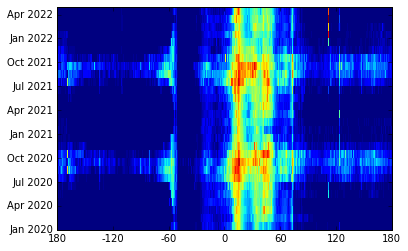

In [17]:
plt.pcolormesh(Nvis,norm=cnorm)
plt.xlim(0,4*360)
plt.ylim(0,28)
plt.xticks([0,4*60,4*120,4*180,4*240,4*300,4*360],[180,-120,-60,0,60,120,180])
plt.yticks([0,3,6,9,12,15,18,21,24,27],
           ['Jan 2020','Apr 2020',
            'Jul 2020','Oct 2020',
            'Jan 2021','Apr 2021',
            'Jul 2021','Oct 2021',
            'Jan 2022','Apr 2022'])

In [18]:
dfout = pd.DataFrame({'ilon':[i for i in range(4*360)]})
dfout.head()

,ilon
0,0
1,1
2,2
3,3
4,4


In [19]:
for ix,t in enumerate(utimes):
    dfout[f'{t}_N'] = Nvis[ix]
    dfout[f'{t}_t'] = timesv[ix]
    dfout[f'{t}_A'] = areasv[ix]
dfout.head()

,ilon,2020-01-01T00:00:00.000000000_N,2020-01-01T00:00:00.000000000_t,2020-01-01T00:00:00.000000000_A,2020-02-01T00:00:00.000000000_N,2020-02-01T00:00:00.000000000_t,2020-02-01T00:00:00.000000000_A,2020-03-01T00:00:00.000000000_N,2020-03-01T00:00:00.000000000_t,2020-03-01T00:00:00.000000000_A,...,2022-01-01T00:00:00.000000000_A,2022-02-01T00:00:00.000000000_N,2022-02-01T00:00:00.000000000_t,2022-02-01T00:00:00.000000000_A,2022-03-01T00:00:00.000000000_N,2022-03-01T00:00:00.000000000_t,2022-03-01T00:00:00.000000000_A,2022-04-01T00:00:00.000000000_N,2022-04-01T00:00:00.000000000_t,2022-04-01T00:00:00.000000000_A
0,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,613.188090,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,1,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,606.992060,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
2,2,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,1501.961186,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3,3,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,891.848176,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
4,4,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,882.502661,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0


In [20]:
dfout.to_csv('./data/routing_tev_Ntimearea_bylon_025.csv',index=False)